In [13]:
%cd /home/dsharonov/projects/kursach/timeseries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from src.models.dataset import TimeSeriesDataset, custom_collate_fn
from src.models.informer import Informer, train, test
import warnings
warnings.filterwarnings("ignore")

/home/dsharonov/projects/kursach/timeseries


In [7]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
np.random.seed(42)
import random
random.seed(42)
torch.manual_seed(42)

In [8]:
seq_length = 60
label_length = 30
pred_length = 10

In [9]:
# ===================== Загрузка и подготовка данных =====================

data = pd.read_csv('/home/dsharonov/projects/kursach/timeseries/data/price_data/gazprom_historical_data.csv', parse_dates=['TRADEDATE'])
data = data[data['BOARDID'] == 'TQBR']

data = data.sort_values('TRADEDATE').reset_index(drop=True)

prices = data['LEGALCLOSEPRICE'].values.reshape(-1, 1)

dates = data['TRADEDATE'].values  # Это массив numpy с датами

train_size = int(len(prices) * 0.7)
train_prices = prices[:train_size]
train_dates = dates[:train_size]
val_prices = prices[train_size:]
val_dates = dates[train_size:]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_val_prices = scaler.transform(val_prices)

train_data = scaled_train_prices
val_data = scaled_val_prices

train_dataset = TimeSeriesDataset(train_data, train_dates, seq_length, label_length, pred_length)
val_dataset = TimeSeriesDataset(val_data, val_dates, seq_length, label_length, pred_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

train_dataset = TimeSeriesDataset(train_data, train_dates, seq_length, label_length, pred_length)
val_dataset = TimeSeriesDataset(val_data, val_dates, seq_length, label_length, pred_length)

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Informer(
    enc_in=1,
    dec_in=1,
    c_out=1,
    seq_len=seq_length,
    label_len=label_length,
    out_len=pred_length,
    d_model=512,
    n_heads=4,
    e_layers=2,
    d_layers=1,
    d_ff=2048,
    dropout=0.2
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

num_epochs = 60
train_losses = []
val_losses = []

save_path = '/home/dsharonov/projects/kursach/timeseries/data/weights/best_informer_model.pth'

    # Обучение модели
train_losses, val_losses, learning_rates = train(
        num_epochs=num_epochs,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        val_loader=val_loader,
        label_length=label_length,
        pred_length=pred_length,
        device=device,
        save_path=save_path
    )

--> Сохранена лучшая модель на эпохе 1 с Val Loss: 0.075860
Epoch [1/60], Train Loss: 0.357515, Val Loss: 0.075860, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 2 с Val Loss: 0.004964
Epoch [2/60], Train Loss: 0.049378, Val Loss: 0.004964, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 3 с Val Loss: 0.002116
Epoch [3/60], Train Loss: 0.034635, Val Loss: 0.002116, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 4 с Val Loss: 0.001993
Epoch [4/60], Train Loss: 0.027017, Val Loss: 0.001993, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 5 с Val Loss: 0.000929
Epoch [5/60], Train Loss: 0.022180, Val Loss: 0.000929, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 6 с Val Loss: 0.000790
Epoch [6/60], Train Loss: 0.016962, Val Loss: 0.000790, Learning Rate: [0.0001]
Epoch [7/60], Train Loss: 0.014282, Val Loss: 0.001824, Learning Rate: [0.0001]
--> Сохранена лучшая модель на эпохе 8 с Val Loss: 0.000632
Epoch [8/60], Train 

Загружена лучшая модель с эпохи 10 с Val Loss: 0.000628


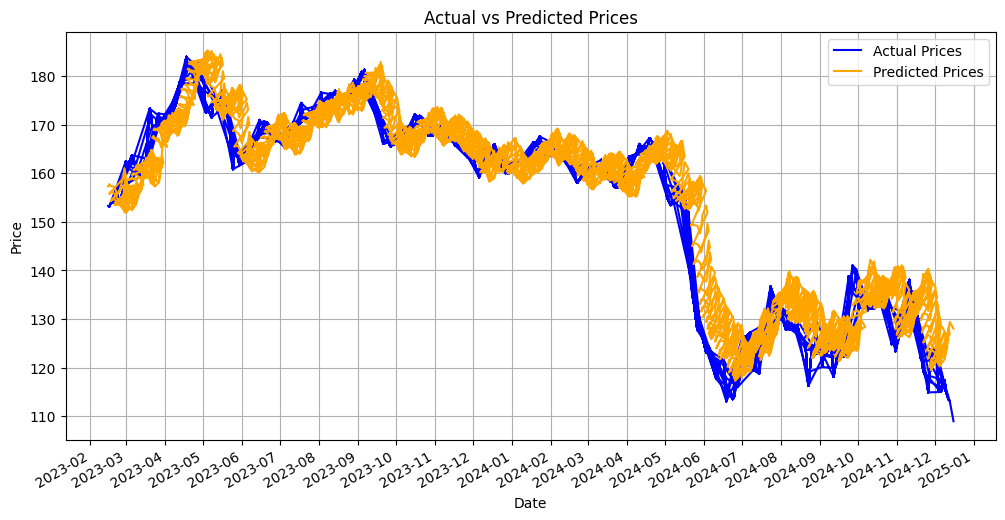

Test Metrics:
MAE: 4.496507167816162
MSE: 40.212806701660156
MAPE: 0.03133687376976013
RMSE: 6.3413567543029785


In [12]:
# Загрузка лучшей модели для тестирования (опционально)
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
best_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']
print(f'Загружена лучшая модель с эпохи {best_epoch} с Val Loss: {best_val_loss:.6f}')

    # Тестирование модели
mae, mse, mape, rmse = test(model, val_loader, scaler, device, label_length, pred_length)
print(f'Test Metrics:\nMAE: {mae}\nMSE: {mse}\nMAPE: {mape}\nRMSE: {rmse}')

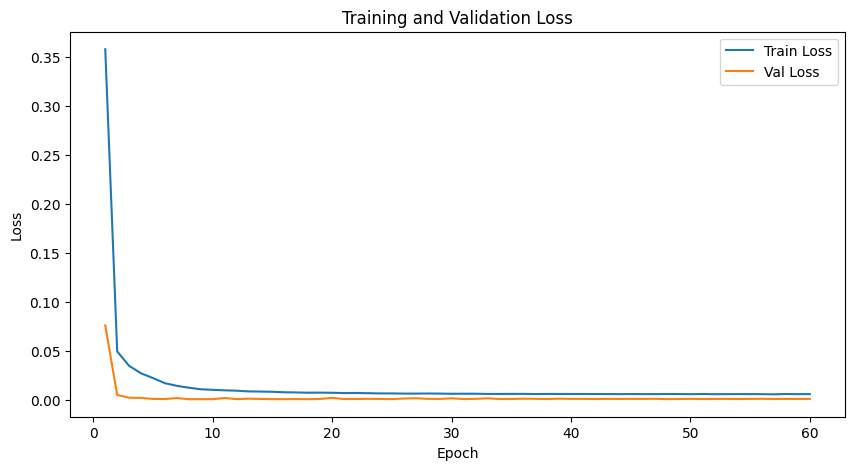

In [14]:
# Визуализация потерь
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()